# Training a CNN 


Modified by : Harold Mouchère + Nicolas Normand / University of Nantes

date : 2023

student : Xianxiang ZHANG with Python 3.9.16 on personal machine

Questions are at the end of the notebook.


In [1]:
import time
import copy
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
 
 
from sklearn.metrics import confusion_matrix
import os
#os.environ['HTTP_PROXY'] = 'http://cache.ha.univ-nantes.fr:3128'
#os.environ['HTTPS_PROXY'] = 'http://cache.ha.univ-nantes.fr:3128'

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Assume that we are on a CUDA machine, then this should print a CUDA device:

print(device)


cpu


## Preparation of the dataset
The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].

In [2]:
transform = transforms.Compose(
    [transforms.Pad(2),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

# size of the mini batch
minibatchsize = 32

datadir = '../data'
fulltrainset = torchvision.datasets.MNIST(root=datadir, train=True,
                                        download=True, transform=transform)

#split the full train part as train and validation (10K samples, some can be ignored):
trainset, validationset, _ignored_part = torch.utils.data.random_split(fulltrainset, [20000,10000, 30000])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=minibatchsize,
                                          shuffle=True, num_workers=0)

validationloader = torch.utils.data.DataLoader(validationset, batch_size=minibatchsize,
                                          shuffle=False, num_workers=0)

testset = torchvision.datasets.MNIST(root=datadir, train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=minibatchsize,
                                         shuffle=False, num_workers=0)

# define the set of class names :
classes = range(0,10)
nb_classes = len(classes)

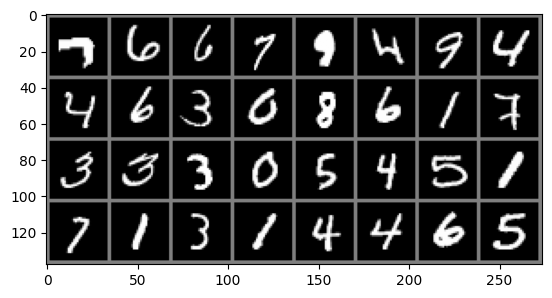

    7     6     6     7


In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img, filename=''):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if filename == '':
        plt.show()
    else:
        plt.savefig(name)

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)


# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


## Define a CNN

Propose a CNN constructor that takes meta-parameters as arguments (nb conv layers, nb kernel per conv, nb FC layers, nb hidden cells per fc)


In [4]:
import torch.nn as nn
import torch.nn.functional as F

# this class define the CNN architecture
# default architecture is close to LeNet5 one
class NetCNN(nn.Module):
    def __init__(self):
        super(NetCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        return x


In [5]:
########################################################################
# Define the network to use :
net = NetCNN()
net.to(device) # move it to GPU or CPU
# show the structure :
print(net)

NetCNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


# Define a Loss function and optimizer

In [6]:
# Let's use a Classification Cross-Entropy loss and SGD with momentum.

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Q1: Optimize the architecture

1. reuse the training function from the previous TP


In [7]:
from xml.etree.ElementTree import tostring


def trainFunc(num_epochs):
    # Definition of arrays to store the results and draw the learning curves
    val_err_array = np.array([])
    train_err_array = np.array([])
    nb_sample_array = np.array([])

    # best system results
    best_val_loss = 1000000
    best_nb_sample = 0
    best_model =  copy.deepcopy(net)

    nb_used_sample = 0
    running_loss = 0.0
    
    print_every = 200
    #part

    

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        start_time = time.time()
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device) # if possible, move them to GPU

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # count how many samples have been used during the training
            nb_used_sample += minibatchsize
            # print/save statistics
            running_loss += loss.item()
            if nb_used_sample % (print_every * minibatchsize) == 0:    # print every ""print_every"" mini-batches
                train_err = (running_loss / (print_every * minibatchsize))
                print('Epoch %d batch %5d ' % (epoch + 1, i + 1))
                print('Train loss : %.3f' % train_err)
                running_loss = 0.0
                #evaluation on validation set
                totalValLoss = 0.0
                with torch.no_grad():
                    for data in validationloader:
                        images, labels = data
                        images, labels = images.to(device), labels.to(device)
                        outputs = net(images)
                        loss = criterion(outputs, labels)
                        totalValLoss += loss.item()
                val_err = (totalValLoss / len(validationset))
                print('Validation loss mean : %.3f' % val_err)
                train_err_array = np.append(train_err_array, train_err)
                val_err_array = np.append(val_err_array, val_err)
                nb_sample_array = np.append(nb_sample_array, nb_used_sample)

                # save the model only when loss is better

                if(val_err<best_val_loss):
                    best_val_loss=val_err
                    best_nb_sample=nb_used_sample
                    best_model =  copy.deepcopy(net)
                
        print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))

    print('Finished Training')

   

    plt.clf()
    plt.xlabel('epoch')
    plt.ylabel('val / train LOSS')
    plt.title('Digit classifier')
    plt.plot(nb_sample_array.tolist(), val_err_array.tolist(), 'b',nb_sample_array.tolist(), train_err_array.tolist(), 'r', [best_nb_sample], [best_val_loss],         'go')
    plt.show()
    # Check the results for each class
    class_correct = list(0. for i in range(nb_classes))
    class_total = list(0. for i in range(nb_classes))
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = best_model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    # compute ... and show results

    for i in range(nb_classes):
        if class_total[i] > 0 :
            print('Accuracy of %5s : %3.2f %% (%d/%d)' % (
                classes[i], 100.0 * class_correct[i] / class_total[i], class_correct[i] , class_total[i]))
        else:
            print('No %5s sample' % (classes[i]))
    # for i in range(nb_classes):
    #     if (class_correct[i] / class_total[i]) < 0.90 :
    #         trainFunc(num_epochs)
    ### save the best model :
    #torch.save(best_model.state_dict(), "./best_model_25.nn")


Epoch 1 batch   200 
Train loss : 0.052
Validation loss mean : 0.052
Epoch 1 batch   400 
Train loss : 0.052
Validation loss mean : 0.052
Epoch 1 batch   600 
Train loss : 0.052
Validation loss mean : 0.052
Epoch 1 of 5 took 8.093s
Epoch 2 batch   175 
Train loss : 0.052
Validation loss mean : 0.052
Epoch 2 batch   375 
Train loss : 0.052
Validation loss mean : 0.052
Epoch 2 batch   575 
Train loss : 0.052
Validation loss mean : 0.052
Epoch 2 of 5 took 8.033s
Epoch 3 batch   150 
Train loss : 0.052
Validation loss mean : 0.052
Epoch 3 batch   350 
Train loss : 0.052
Validation loss mean : 0.052
Epoch 3 batch   550 
Train loss : 0.052
Validation loss mean : 0.052
Epoch 3 of 5 took 7.920s
Epoch 4 batch   125 
Train loss : 0.052
Validation loss mean : 0.052
Epoch 4 batch   325 
Train loss : 0.052
Validation loss mean : 0.052
Epoch 4 batch   525 
Train loss : 0.052
Validation loss mean : 0.052
Epoch 4 of 5 took 8.865s
Epoch 5 batch   100 
Train loss : 0.052
Validation loss mean : 0.052
Epo

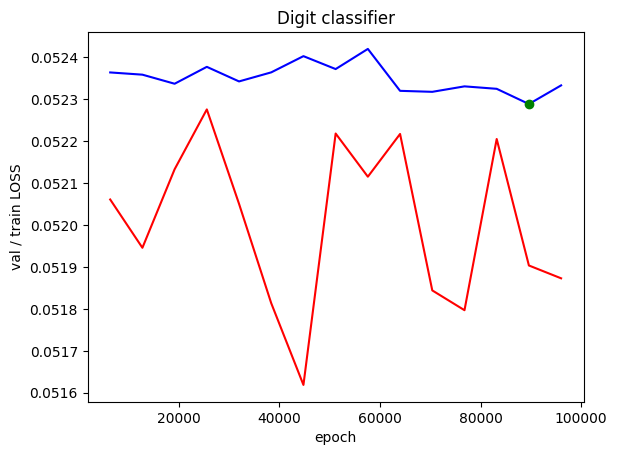

Accuracy of     0 : 97.86 % (959/980)
Accuracy of     1 : 99.03 % (1124/1135)
Accuracy of     2 : 96.61 % (997/1032)
Accuracy of     3 : 98.32 % (993/1010)
Accuracy of     4 : 97.56 % (958/982)
Accuracy of     5 : 0.00 % (0/892)
Accuracy of     6 : 98.33 % (942/958)
Accuracy of     7 : 96.89 % (996/1028)
Accuracy of     8 : 0.00 % (0/974)
Accuracy of     9 : 95.84 % (967/1009)


In [28]:
best_model =  copy.deepcopy(net)
#train
trainFunc(5)

2. Analyse your network : recognition rate, confusion matrix 


In [29]:
def evaluate(net, testloader):
    correct = 0
    total = 0
    nb_classes = 10
    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

    accuracy = 100 * correct / total
    print('Accuracy of the network on the test images: %d %%' % (accuracy))
    print('Confusion matrix:')
    print(confusion_matrix)


In [30]:
evaluate(best_model, testloader)


Accuracy of the network on the test images: 79 %
Confusion matrix:
tensor([[9.6700e+02, 1.0000e+00, 1.0000e+00, 0.0000e+00, 3.0000e+00, 0.0000e+00,
         3.0000e+00, 2.0000e+00, 0.0000e+00, 3.0000e+00],
        [1.0000e+00, 1.1290e+03, 3.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [8.0000e+00, 5.0000e+00, 9.7900e+02, 2.1000e+01, 4.0000e+00, 0.0000e+00,
         0.0000e+00, 1.5000e+01, 0.0000e+00, 0.0000e+00],
        [3.0000e+00, 0.0000e+00, 2.0000e+00, 9.9200e+02, 1.0000e+00, 0.0000e+00,
         0.0000e+00, 8.0000e+00, 0.0000e+00, 4.0000e+00],
        [0.0000e+00, 1.0000e+00, 5.0000e+00, 1.0000e+00, 9.5000e+02, 0.0000e+00,
         4.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+01],
        [1.1100e+02, 7.0000e+00, 8.0000e+00, 4.7500e+02, 3.1000e+01, 0.0000e+00,
         4.0000e+01, 3.3000e+01, 0.0000e+00, 1.8700e+02],
        [1.5000e+01, 2.0000e+00, 1.0000e+00, 0.0000e+00, 8.0000e+00, 0.0000e+00,
         9.3200e+0

3. select one meta-paramter (or 2 depending on the available time) and draw the curve showing the loss depending  on this parameter

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


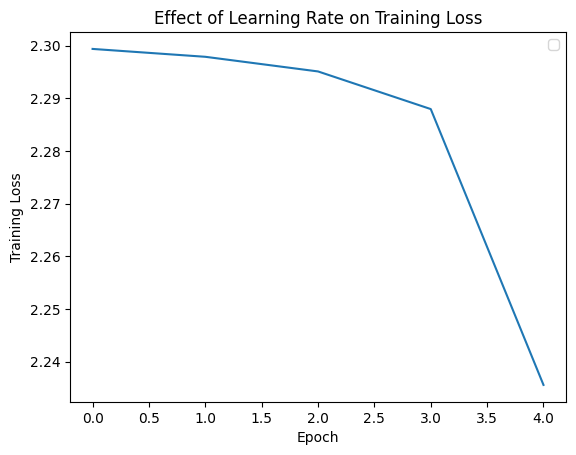

In [11]:

num_epochs = 5
train_loss = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device) # if possible, move them to GPU
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss.append(running_loss/len(trainloader))

plt.plot(train_loss)

plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Effect of Learning Rate on Training Loss')
plt.legend()
plt.show()


4. evaluate and analyse the best network, compute the number of free parameters (complexity). See documentation of [nn.parameter](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html).

In [12]:
import torch
import torch.nn as nn

# Count the number of parameters
num_params = sum(p.numel() for p in best_model.parameters() if p.requires_grad)

print(f"Number of free parameters: {num_params}")


Number of free parameters: 61706


## Q2: Draw the Pareto front collectively
Agregate all the results from the group to draw a full Pareto front. Do not hesitate to change the architecture to explore the full tradeoff **complexity/error rate**.

In [13]:
@torch.no_grad()
def get_all_preds(model, loader):
  all_preds = torch.tensor([])
  for batch in loader:
      images, labels = batch


      preds = model(images)
      all_preds = torch.cat(
          (all_preds, preds)
          ,dim=0
      )
  return all_preds

Accuracy of the network on the test images: 17.48 %
Accuracy of the network on the test images: 31.85 %
Accuracy of the network on the test images: 83.50 %
Accuracy of the network on the test images: 68.21 %
Accuracy of the network on the test images: 86.63 %


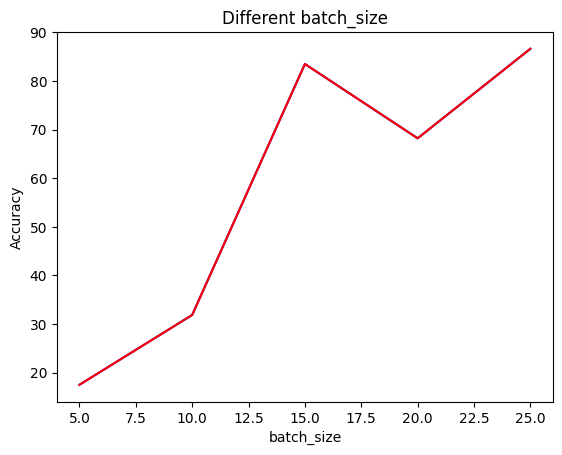

In [14]:
import numpy as np
model_5 = NetCNN()
model_5.load_state_dict(torch.load("best_model_5.nn"))
model_10 = NetCNN()
model_10.load_state_dict(torch.load("best_model_10.nn"))
model_15 = NetCNN()
model_15.load_state_dict(torch.load("best_model_15.nn"))
model_20 = NetCNN()
model_20.load_state_dict(torch.load("best_model_20.nn"))
model_25 = NetCNN()
model_25.load_state_dict(torch.load("best_model_25.nn"))

def test_acc(model,testloader):
    correct = 0
    total = 0
    acc=0
    pre = get_all_preds(model, testloader)
    correct=(pre.argmax(dim=1) == testloader.dataset.targets).sum().item()
    total=len(pre.argmax(dim=1))
    print('Accuracy of the network on the test images: %.2f %%' % (100 * correct / total))
    return 100 * correct / total
acc_array = np.array([])
acc_array = np.append(acc_array, test_acc(model_5,testloader))
acc_array = np.append(acc_array, test_acc(model_10,testloader))
acc_array = np.append(acc_array, test_acc(model_15,testloader))
acc_array = np.append(acc_array, test_acc(model_20,testloader))
acc_array = np.append(acc_array, test_acc(model_25,testloader))
batch_size_array = np.array([5,10,15,20,25])
plt.clf()
plt.xlabel('batch_size')
plt.ylabel('Accuracy')
plt.title('Different batch_size')
plt.plot(batch_size_array.tolist(), acc_array.tolist(), 'b',batch_size_array.tolist(), acc_array.tolist(), 'r')
plt.show()

Models with fewer parameters tend to have lower validation accuracy, while models with more parameters tend to have higher validation accuracy. 

We can see that some models with a large number of parameters achieve only a small improvement in validation accuracy compared to models with fewer parameters, suggesting that we may be able to simplify the architecture of these models without sacrificing much accuracy. Conversely, we can also see that some models with a small number of parameters are still relatively complex and achieve relatively low accuracy, suggesting that we may need to add more capacity to the model to improve its performance.